## BioFaceNet

Author - Parth Agrawal

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader

import tqdm
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
import os 
import zipfile 
import gdown

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Download Dataset

In [4]:
data_root = 'Data/celeba'

dataset_folder = f'{data_root}/img_align_celeba'

url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'


download_path = f'{data_root}/img_celeba'


if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

gdown.download(url, download_path, quiet=False)

## Use TQDM
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/Data/celeba/img_celeba
1.44GB [00:12, 117MB/s]


## Create Dataset

In [5]:
def load_images(path,limit = 10):
  files = os.listdir(path)
  images_arr = []
  n = len(files)
  i = 0 
  while(i < limit):
    images_arr.append(plt.imread(path + '/' + files[i]) / 255)
    i += 1
  return np.array(images_arr)

In [6]:
PATH = "/content/Data/celeba/img_align_celeba/img_align_celeba"
data = load_images(PATH)

Size of the Dataset : (10, 218, 178, 3)


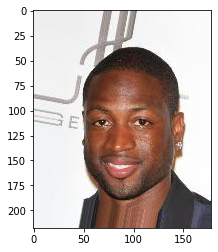

In [7]:
print(f'Size of the Dataset : {data.shape}')
plt.imshow(data[0])

## Dataloader

In [8]:
# Change the validation Dataset
data_tensor = torch.tensor(data).float().to(device)

dataloaders = {
    'train': DataLoader(data_tensor, batch_size=32, shuffle=False),
    'val': DataLoader(data_tensor, batch_size=32, shuffle=False)
}

## Model

### Encoder Architecture

In [30]:
class unet(nn.Module):
  def __init__(self,in_channels):
    super(unet,self).__init__()
    self.conv1_down = nn.Conv2d(in_channels,32,(3,3),stride = 1,padding = 1)
    self.batchnorm1_down = torch.nn.BatchNorm2d(32)
    self.conv2_down = nn.Conv2d(32,64,(3,3),stride = 1,padding = 1)
    self.batchnorm2_down = torch.nn.BatchNorm2d(64)
    self.conv3_down = nn.Conv2d(64,128,(3,3),stride = 1,padding = 1)
    self.batchnorm3_down = torch.nn.BatchNorm2d(128)
    self.conv4_down = nn.Conv2d(128,256,(3,3),stride = 1,padding = 1)
    self.batchnorm4_down = torch.nn.BatchNorm2d(256)
    self.conv5_down = nn.Conv2d(256,512,(3,3),stride = 1,padding = 1)
    self.batchnorm5_down = torch.nn.BatchNorm2d(512)
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d((2,2),stride = 2)
    self.skip_connections = []
    
    self.upsample_1 = torch.nn.Upsample(size=(27,22))
    self.conv1_up = nn.Conv2d(768,256,(3,3),stride = 1,padding = 1)
    self.batchnorm1_up = torch.nn.BatchNorm2d(256)
    
    self.upsample_2 = torch.nn.Upsample(size=(54,44))
    self.conv2_up = nn.Conv2d(384,128,(3,3),stride = 1,padding = 1)
    self.batchnorm2_up = torch.nn.BatchNorm2d(128)

    self.upsample_3 = torch.nn.Upsample(size=(109,89))
    self.conv3_up = nn.Conv2d(192,64,(3,3),stride = 1,padding = 1)
    self.batchnorm3_up = torch.nn.BatchNorm2d(64)
    
    self.upsample_4 = torch.nn.Upsample(size=(218,178))
    self.conv4_up = nn.Conv2d(96,32,(3,3),stride = 1,padding = 1)
    self.batchnorm4_up = torch.nn.BatchNorm2d(32)
    
    
    self.conv5_up = nn.Conv2d(32,1,(3,3),stride = 1,padding = 1)
  


  def forward(self,x):
    print(x.shape)
    x = x.permute(0,3,1,2)
    print(x.shape)
    x = self.conv1_down(x)
    x = self.batchnorm1_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    print(x.shape)
    x = self.conv2_down(x)
    x = self.batchnorm2_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    print(x.shape)
    x = self.conv3_down(x)
    x = self.batchnorm3_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    print(x.shape)
    x = self.conv4_down(x)
    x = self.batchnorm4_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    print(x.shape)
    x = self.conv5_down(x)
    x = self.batchnorm5_down(x)
    x = self.relu(x)
    print(x.shape)

    print("----skip-----")

    print(len(self.skip_connections))
    for i in range(len(self.skip_connections)):
      print(self.skip_connections[i].shape)

    print("___ UPS ---")

    print(x.shape)
    x = self.upsample_1(x)
    print(x.shape,self.skip_connections[-1].shape)
    x = torch.cat((x,self.skip_connections[-1]),1)
    print(x.shape)
    x = self.conv1_up(x)
    x = self.batchnorm1_up(x)
    x = self.relu(x)
    print(x.shape)

    x = self.upsample_2(x)
    x = torch.cat((x,self.skip_connections[-2]),1)
    print(x.shape)
    x = self.conv2_up(x)
    x = self.batchnorm2_up(x)
    x = self.relu(x)
    print(x.shape)

    x = self.upsample_3(x)
    x = torch.cat((x,self.skip_connections[-3]),1)
    print(x.shape)
    x = self.conv3_up(x)
    x = self.batchnorm3_up(x)
    x = self.relu(x)
    print(x.shape)

    x = self.upsample_4(x)
    x = torch.cat((x,self.skip_connections[-4]),1)
    print(x.shape)
    x = self.conv4_up(x)
    x = self.batchnorm4_up(x)
    x = self.relu(x)
    print(x.shape)

    x = self.conv5_up(x)
    print(x.shape)

    return x

### Train

In [31]:
## Still need to make modifications

def train(model,optimizer,epochs,loss_fn):
  best_model = None

  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    for phase in ['train','val']:
      train_loss = 0
      batch_idx = 0

      if phase == 'train':
        model.train()
      else:
        model.eval()
            
      for X in dataloaders[phase]:
        inputs = X.to(device)
        batch_idx += 1

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = loss_fn(outputs,outputs) # Change the loss function 

          if phase == 'train':
            loss.backward()
            optimizer.step()

          train_loss += loss

  return model,train_loss

In [32]:
model = unet(in_channels=3).to(device)
for X in dataloaders['train']:
  model(X)
  break

torch.Size([10, 218, 178, 3])
torch.Size([10, 3, 218, 178])
torch.Size([10, 32, 109, 89])
torch.Size([10, 64, 54, 44])
torch.Size([10, 128, 27, 22])
torch.Size([10, 256, 13, 11])
torch.Size([10, 512, 13, 11])
----skip-----
4
torch.Size([10, 32, 218, 178])
torch.Size([10, 64, 109, 89])
torch.Size([10, 128, 54, 44])
torch.Size([10, 256, 27, 22])
___ UPS ---
torch.Size([10, 512, 13, 11])
torch.Size([10, 512, 27, 22]) torch.Size([10, 256, 27, 22])
torch.Size([10, 768, 27, 22])
torch.Size([10, 256, 27, 22])
torch.Size([10, 384, 54, 44])
torch.Size([10, 128, 54, 44])
torch.Size([10, 192, 109, 89])
torch.Size([10, 64, 109, 89])
torch.Size([10, 96, 218, 178])
torch.Size([10, 32, 218, 178])
torch.Size([10, 1, 218, 178])
